In [16]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Lambda
from keras import backend as K
 
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import defaultdict
from keras.datasets import mnist
import warnings
warnings.filterwarnings('ignore')

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x = np.append(x_train, x_test)
y = np.append(y_train, y_test)

x = x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
y = y.astype(np.int32)
 
# shuffle images and labels
indices = np.arange(len(x))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]
 
def get_triples_indices(grouped, n):
    num_classes = len(grouped)
    positive_labels = np.random.randint(0, num_classes, size=n)
    negative_labels = (np.random.randint(1, num_classes, size=n) + positive_labels) % num_classes
    triples_indices = []
    for positive_label, negative_label in zip(positive_labels, negative_labels):
        negative = np.random.choice(grouped[negative_label])
        positive_group = grouped[positive_label]
        m = len(positive_group)
        anchor_j = np.random.randint(0, m)
        anchor = positive_group[anchor_j]
        positive_j = (np.random.randint(1, m) + anchor_j) % m
        positive = positive_group[positive_j]
        triples_indices.append([anchor, positive, negative])
    return np.asarray(triples_indices)
 
def get_triples_data(x, grouped, n):
    indices = get_triples_indices(grouped, n)
    return x[indices[:,0]], x[indices[:,1]], x[indices[:,2]]
 
def triplet_loss(inputs, dist='sqeuclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = K.mean(positive_distance, axis=-1, keepdims=True)
        negative_distance = K.mean(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        loss = K.maximum(0.0, 10 + loss)
    elif margin == 'softplus':
        loss = K.log(1 + K.exp(loss))
    return K.mean(loss)
 
from keras.models import load_model
 
def build_model(input_shape):
   
    base_input = Input(input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(base_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(2, activation='linear')(x)
    #     x = Lambda(lambda x: K.l2_normalize(x, axis=-1))(x) # force the embedding onto the surface of an n-sphere
    embedding_model = Model(base_input, x, name='embedding')
   
    anchor_input = Input(input_shape, name='anchor_input')
    positive_input = Input(input_shape, name='positive_input')
    negative_input = Input(input_shape, name='negative_input')
   
    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)
 
    inputs = [anchor_input, positive_input, negative_input]
    outputs = [anchor_embedding, positive_embedding, negative_embedding]
    triplet_model = Model(inputs, outputs)
    triplet_model.add_loss(K.mean(triplet_loss(outputs)))
    triplet_model.compile(loss=None, optimizer='adam') #loss should be None
 
    return embedding_model, triplet_model
 
def triplet_generator(x, y, batch_size):
    grouped = defaultdict(list)
    for i, label in enumerate(y):
        grouped[label].append(i)
       
    while True:
        x_anchor, x_positive, x_negative = get_triples_data(x, grouped, batch_size)
        yield ({'anchor_input': x_anchor,
               'positive_input': x_positive,
               'negative_input': x_negative},
               None)
 
batch_size = 16
steps_per_epoch = 16
epochs = 30
 
embedding_model, triplet_model = build_model((28, 28, 1))
 
history = triplet_model.fit_generator(triplet_generator(x, y, batch_size),
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=epochs,
                                      verbose=1)

Epoch 1/30
16/16 [==============================] - 1s 77ms/step - loss: 9.9670
Epoch 2/30
16/16 [==============================] - 1s 53ms/step - loss: 9.0648
Epoch 3/30
16/16 [==============================] - 1s 56ms/step - loss: 7.0772
Epoch 4/30
16/16 [==============================] - 1s 56ms/step - loss: 4.7689
Epoch 5/30
16/16 [==============================] - 1s 54ms/step - loss: 5.3793
Epoch 6/30
16/16 [==============================] - 1s 54ms/step - loss: 4.9465
Epoch 7/30
16/16 [==============================] - 1s 54ms/step - loss: 4.5420
Epoch 8/30
16/16 [==============================] - 1s 57ms/step - loss: 5.2855
Epoch 9/30
16/16 [==============================] - 1s 58ms/step - loss: 3.7462
Epoch 10/30
16/16 [==============================] - 1s 57ms/step - loss: 4.7631
Epoch 11/30
16/16 [==============================] - 1s 58ms/step - loss: 4.5848
Epoch 12/30
16/16 [==============================] - 1s 58ms/step - loss: 4.2178
Epoch 13/30
16/16 [==================

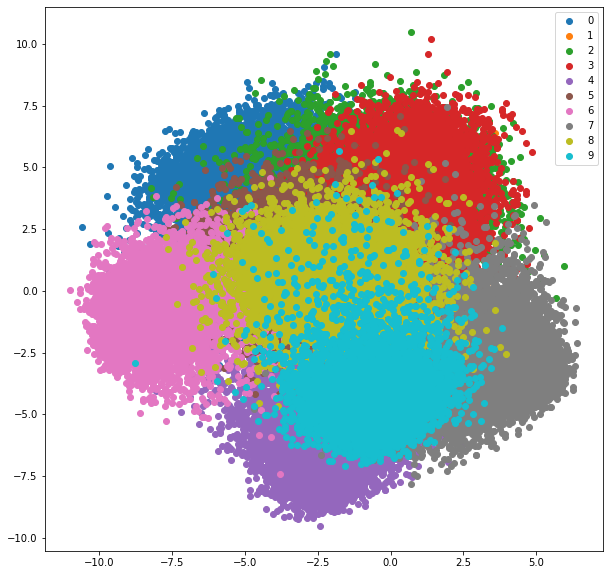

In [17]:
from sklearn.utils.multiclass import unique_labels

list_name_id = unique_labels(y)

plt.figure(figsize=(10,10))
for i in range(0, len(list_name_id), 1):
  list_files = np.where(y == list_name_id[i])[0]
  images = []
  for j in range(0,len(list_files), 1):
    images.append(x[list_files[j]])
  dots = []
  for k in range(0,len(images),1):
    dots.append(embedding_model.predict([images[k:k+1]])[0])
  dots = np.array(dots)
  plt.plot(dots[:,0], dots[:,1],'o', label = list_name_id[i])
  plt.legend(loc = "best")